# Exploring Practical Recommendation Systems In Neo4j
### __An Example With Collaborative Leveraging Graph Data Science and Machgine Learning__

In this notebook we explore how to get started with practical & scalable recommendation in graph. We will walk through a fundamental example with recipe recommendation on dataset containing 231k recipes and around 226K users. We will leverage Neo4j and the Graph Data Science (GDS) library to quickly predict similar recipes based on user preferences and enable sub-second, rank-ordered, recommendation queries personalized to each user.

This notebook is structured as follows: 

1. Setup some configurations and helper functions to allow us to work with the graph. 
2. Go over the source dataset and graph we will be using along with how to query basic profiling statistics to help us understand the graph and better prepare for analysis. 
3. Briefly introduce a technique called Collaborative filtering (CF) which will be our mechanism for recommendation in this notebook
4. Explore Applying the Cypher query language for basic CF
5. Scaling CF with the Graph Data Science (GDS) Library, leveraging Node embeddings and an ML technique called K-Nearest Neighbor (KNN).

## Notebook Setup

In [64]:
from graphdatascience import GraphDataScience
import pandas as pd
import configparser
import os
import numpy as np
import importlib
from tqdm.notebook import tqdm

# Set pandas options
pd.set_option('display.width', 0)
pd.set_option('display.max_colwidth', 500)
pd.set_option('display.max_rows', 12)

In [65]:
# Import custom modules
from src import queries, utils

# Reload modules
importlib.reload(queries)
importlib.reload(utils)

print('Modules reloaded')

Modules reloaded


### Neo4j Settings
The `NEO4J_PROPERTIES_FILE` is an ini configuration file for Neo4j properties so this notebook can connect to
your Neo4j instance and load data. The ini file should be formatted as follows
```
[NEO4J]
PASSWORD=<password>
USERNAME=<database name, is 'neo4j' by default>
HOST=<host uri>

```

Set `NEO4J_PROPERTIES_FILE` to None or any non-existent location to use the below defaults
```
HOST = 'neo4j://localhost'
USERNAME = 'neo4j'
PASSWORD = 'password'
```

In [66]:
NEO4J_PROPERTIES_FILE = None #'/path/to/your/file.ini'
# Replace with your Neo4j import directory
NEO4J_IMPORT_DIR = '/home/luigi/.config/Neo4j Desktop/Application/relate-data/dbmss/dbms-c5c50094-d809-4eeb-84f4-745becc1cd52/import'

In [67]:
# Using an ini file for credentials, otherwise providing defaults
HOST = 'bolt://localhost:7687'
DATABASE = 'neo4j'
PASSWORD = 'LU?vVtYf8])9;^z'

if NEO4J_PROPERTIES_FILE is not None and os.path.exists(NEO4J_PROPERTIES_FILE):
    config = configparser.RawConfigParser()
    config.read(NEO4J_PROPERTIES_FILE)
    HOST = config['NEO4J']['HOST']
    USERNAME = config['NEO4J']['USERNAME']
    PASSWORD = config['NEO4J']['PASSWORD']
    print('Using custom database properties')
else:
    print('Could not find database properties file, using defaults')

Could not find database properties file, using defaults


In [68]:
# Create a connection to the database
gds = GraphDataScience(HOST, auth=(DATABASE, PASSWORD))

```
//visualize schema in Neo4j Browser
neo4j$ CALL db.schema.visualization();
```
![image](./image/nodes.png)

We see that recipes are modeled as nodes and can can be "submitted" or "reviewed" by users which are also modeled as nodes. 
Additionally, News also have ingredients and it's relation with recipe. These will be useful for extended analysis, but we will not be using them in this example. Our primary interest here is to get started with users and their reviews to derive recommendations.

### Graph Data Profiling
Before diving right into into analysis, it is helpful to inspect some high level statistics of graph to get a better sense of size and connectivity.

#### Aggregate Counts
Let's start with high node and relationships counts. These functions assume [APOC](https://neo4j.com/developer/neo4j-apoc/) is installed on your Neo4j DB.

In [69]:
# Total node count
queries.get_node_counts(gds)


Query executed in 0.01 seconds


,label,nodeCount
0,User,21199
1,Recipe,231637


In [70]:
# total relationship counts
queries.get_relationship_counts(gds)


Query executed in 0.01 seconds


,type,relationshipCount
0,SUBMITTED,194946
1,REVIEWED,30000


As far as search recommendation is concerns this is a relatively modestly sized graph, with only around 226K users, 231k news articles, and around 500k total creations/reviews.

#### Reviews Distributions
Next, we can look at the distribution of events per user. It is helpful to check this distribution to make sure that:
1. The graph is reasonably well connected as the quality of our upcoming recommendation technique will depend on a reasonably well connected graph.
2. We do not have any large [supernodes](https://medium.com/neo4j/graph-modeling-all-about-super-nodes-d6ad7e11015b), i.e. nodes with very high numbers of relationships. What qualifies as a supernode varies greatly by use case. For this, I would be concerned about users with tens of thousands of clicks.

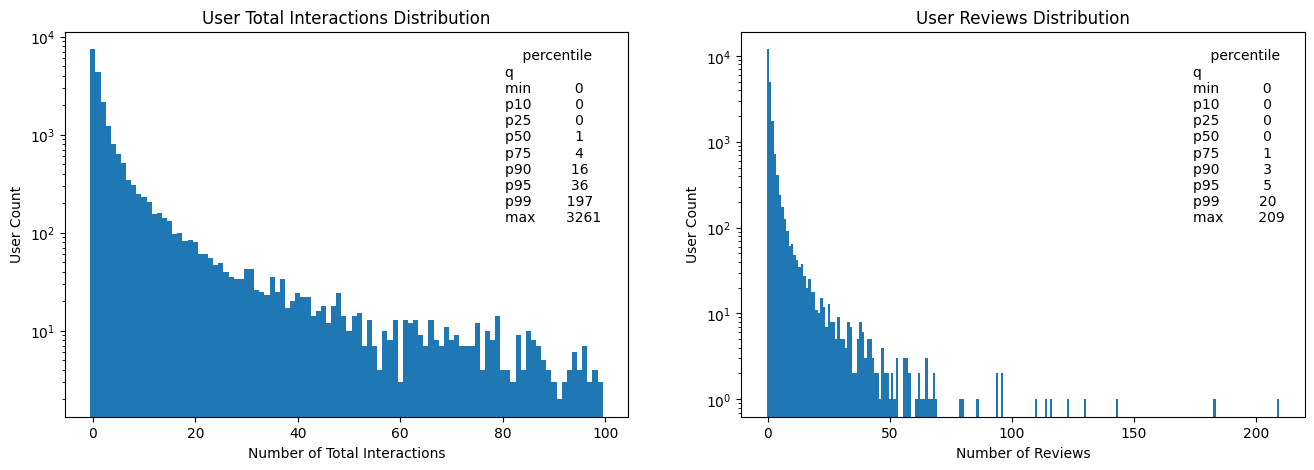

In [71]:
# Define the top number of rewires
n_rew = 100

# Plot interactions distribution
utils.plot_interactions_distribution(gds, n_rew)

The above shows the distributions for total interactions (`REVIEWED` and `SUBMITTED`) as well as reviews (just `REVIEWED`) by user. We see that the distributions have heavy left tails, showing that activity is not uniformly distributed among users, but rather there is relatively small fraction of users that account for a large number of interactions. This is somewhat expected. 

We can do a similar breakdown for Recipe below.

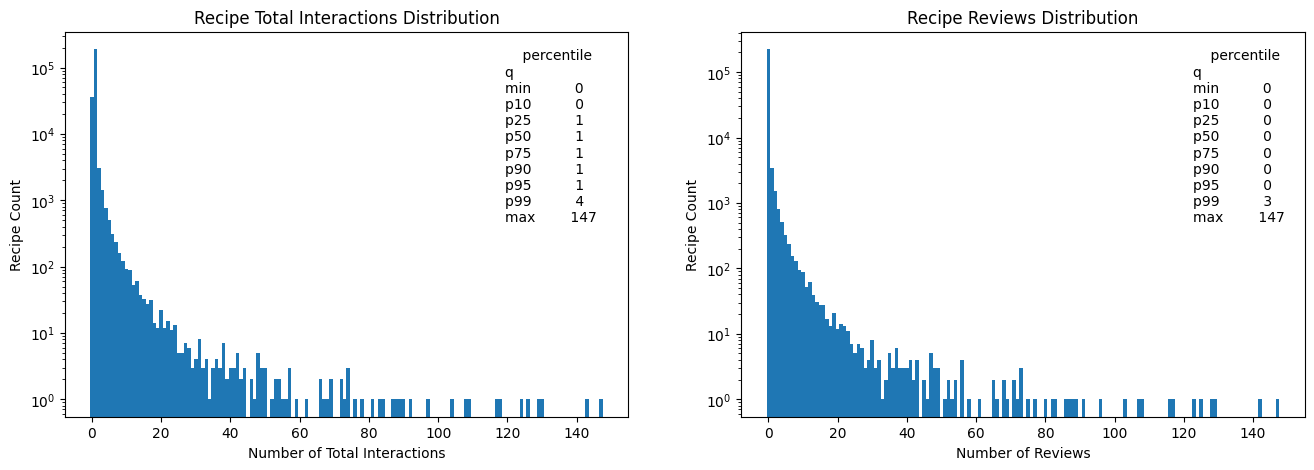

In [72]:
# Plot interactions distribution
utils.plot_recipe_interactions_distribution(gds, n_rew)

## Collaborative Filtering (CF)

There are many different types of recommendations systems. In this example we will apply a technique called Collaborative Filtering (CF), which is the practice of automatically predicting a user's preferences based on the actions of similar users.

### User vs Item Based CF
Roughly speaking there are two main classes of collaborative filtering
1. User-based, which is focuses on directly calculating similarity between users based on their interaction with items
2. Item-based, which measures the similarity between pairs of items based on correlated user activity, such as the same users liking, viewing, rating, or otherwise similarly interacting with items

Our approach today will focus on the later, item-based CF. Item-based CF will be more manageable and scalable then user-based CF for many problem domains. There are a couple reasons for this. First, because there are way fewer items then users in most applied cases so there are less entities to compare. Second, and perhaps more importantly, User preferences can also be dynamic and change overtime. For example, in a Movie example, a user could be mostly interested in Sci Fi movies but go through a brief stint in Westerns, and making recommendations for Westerns to other Sci Fi fans who historically viewed the same things may not be the best thing. Often the best indicator of a user's current interest is their most recent activity, and item based filtering gives you better flexibility to find similarities based off the most recent item(s) submitted, rated, etc.

## Basic Cypher Queries for CF
From here we could try just using Cypher to accomplish basic Collaborative Filtering. For example, take the below user and the news they clicked. You can see a mixed interest between autos, finance, US news, and a couple other categories.

In [73]:
# Select a random user that has at least n_rew reviews
random_user_query = queries.get_random_user(gds, n_rew)

# Get the user ID
USER_ID = str(random_user_query['randomUserID'][0])
print(f"Selected user {USER_ID} with", random_user_query['reviewCount'][0], 'reviews')


Query executed in 0.02 seconds
Selected user 424680 with 209 reviews


In [74]:
# Print some of the user interactions
user_interactions = queries.get_user_interactions(gds, USER_ID)
interacted_recipes = list(set(user_interactions['recipeID']))

# Show result
user_interactions.head()


Query executed in 0.05 seconds


,recipeID,name,nutrition,n_ingredients,interactionDate,interactionType
0,416414,restaurant style chinese orange chicken with spring peas,"[389.4, 10.0, 73.0, 28.0, 72.0, 6.0, 14.0]",18,2010-10-14,REVIEWED
1,333002,russian style chicken,"[395.4, 23.0, 227.0, 47.0, 3.0, 11.0, 22.0]",5,2010-07-22,REVIEWED
2,399212,dried cherry couscous salad,"[85.9, 3.0, 6.0, 4.0, 5.0, 1.0, 4.0]",10,2010-07-19,REVIEWED
3,169915,tortellini with vegetables,"[176.2, 16.0, 34.0, 8.0, 14.0, 15.0, 4.0]",12,2010-07-18,REVIEWED
4,238268,favorite omelet,"[580.0, 66.0, 10.0, 17.0, 84.0, 96.0, 1.0]",9,2010-07-06,REVIEWED


Assuming we can measure the similarity of user interests via commonly reviewed recipes, we can do a three hop query to find potential recommendations for user `27711` based on the activity of users that reviewed the same recipe as `27711` (or even reviewed their recipe high).

With the below query we can get an aggregate count of the nodes we would need to traverse over to get the recommendations.

In [75]:
# Get the number of possible suggestions
queries.get_hops_count(gds, USER_ID)


Query executed in 0.19 seconds


,userId,interactedRecipesCount,likeUsersCount,potentialRecommendationsCount
0,424680,197,622,74950


While the above can work well in some cases, and while it can certainly be a massive improvement from joining SQL tables or cross-walking over document stores, notice that we get a lot of potential recommendations back (about 13K). And this is just a sample of the the total dataset.

For production use cases where recommendations will need to be queried frequently, this method will have trouble scaling as the number of users, amount of content, and/or observed engagement grows. We need some other strategy to help narrow down the results. There are a few different ways we can accomplish this, but one robust and scalable way to do so is with the [Neo4j Graph Data Science (GDS) Library](https://neo4j.com/docs/graph-data-science/current/).

### Recommendation based on favorite ingredients
First let's make a list of excluded ingredients. Those ingredients won't be considered as they're common ingredients in recipies.

In [76]:
# Define a list of (common) ingredients to exclude
excluded_ingr = [
    'butter', 'salt', 'sugar', 'all-purpose flour', 'baking powder', 'baking soda', 
    'olive oil', 'pepper', 'water', 'flour', 'eggs', 'egg'
]
# Define how many favorite ingredients we want to take into account
max_fav_ingr = 10
# Define how many recipe to suggest
n_suggestions = 5

In [77]:
# Compute top 5 user ingredients
favIngr = queries.get_user_favourite_ingredients(
    gds, 
    USER_ID, 
    max_fav_ingr, 
    excluded_ingr
)

# Save data
favorite_ingredients = list(favIngr['favoriteIngredient'])

# Show result
favIngr[['favoriteIngredient', 'favCount']]


Query executed in 0.01 seconds


,favoriteIngredient,favCount
0,granulated sugar,257
1,unsalted butter,237
2,ground cinnamon,101
3,milk,92
4,onion,90
5,vanilla extract,84
6,brown sugar,83
7,orange juice,74
8,lemon juice,67
9,honey,61


In [78]:
# Suggest recipes based on user's favorites ingredients
favIngrRec = queries.get_recipe_w_ingreds(
    gds, 
    n_suggestions, 
    interacted_recipes, 
    favorite_ingredients, 
    excluded_ingr
)

# Show result
favIngrRec.head()


Query executed in 1.72 seconds


,recipeID,recipeName,recipeIngredients,matchCount,totalIngredients,relevanceScore
0,148850,cinnamon toast toddy,"[brown sugar, ground cinnamon, unsalted butter, milk]",4,4,1.609438
1,275828,broiled pineapple with rum sauce,"[unsalted butter, vanilla extract, brown sugar, granulated sugar, fresh pineapple, dark rum, ground cinnamon]",5,7,1.485315
2,138317,mexican hot cocoa,"[milk, vanilla extract, nestle toll house baking cocoa, ground cinnamon, granulated sugar]",4,5,1.433408
3,168548,sweet plantains,"[plantains, ground cinnamon, unsalted butter, vanilla extract, brown sugar]",4,5,1.433408
4,225069,atole,"[ground cinnamon, milk, vanilla extract, masa harina, brown sugar]",4,5,1.433408


### Recommendation based on nutritonal properties
In addition to suggestin recipes based on preferred ingredients, it's also possible to identify user preferences on nutritional values and make suggestions based on this data. We will study a user favorite nutritional values based on both the recipes he has submitted and reviewed.

In [79]:
# Obtain nutritional values
nutrVal = queries.get_user_nutritional_values(
    gds, 
    USER_ID
)

# Show result
nutrVal.head()


Query executed in 0.12 seconds


,recipeID,calories,totalFat,sugar,sodium,protein
0,226512,319.7,16.0,178.0,6.0,9.0
1,393840,161.3,14.0,12.0,10.0,9.0
2,307716,219.6,31.0,16.0,2.0,5.0
3,324127,153.2,0.0,89.0,0.0,1.0
4,414823,105.2,10.0,38.0,0.0,3.0


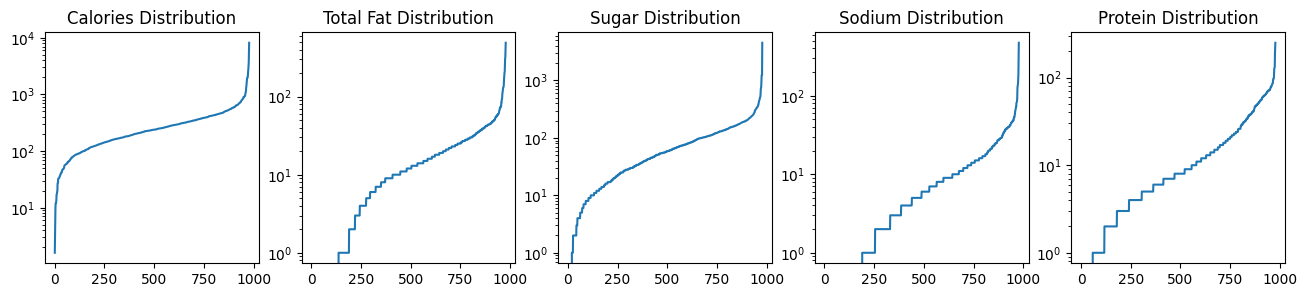

50% of calories data lies between 140.40 and 373.00
50% of total fat data lies between 4.00 and 24.00
50% of sugar data lies between 21.50 and 116.00
50% of sodium data lies between 1.00 and 13.00
50% of protein data lies between 4.00 and 19.00


In [80]:
# Plot nutritional values
utils.plot_nutritional_values(nutrVal)
# Get nutritional values ranges
calories_range, fat_range, sugar_range, sodium_range, protein_range = utils.get_nutritional_values(nutrVal)

In [81]:
# Suggest recipe based on nutritional values
nutrValRec = queries.get_recipe_nutritional_values(
    gds, 
    n_suggestions, 
    interacted_recipes, 
    calories_range, 
    fat_range, 
    sugar_range, 
    sodium_range, 
    protein_range
)

# Show result
nutrValRec.head()


Query executed in 0.07 seconds


,recipeID,recipeName,nutritionList
0,100013,no crust pumpkin pie,"[231.5, 8.0, 115.0, 12.0, 11.0, 13.0, 13.0]"
1,100028,my special bread pudding,"[171.8, 12.0, 69.0, 2.0, 7.0, 23.0, 6.0]"
2,100068,whisky or bourbon baked sweet potatoes or yams,"[324.1, 9.0, 56.0, 2.0, 5.0, 18.0, 20.0]"
3,100083,herb mustard roast potatoes,"[233.4, 12.0, 12.0, 10.0, 10.0, 5.0, 12.0]"
4,100124,sun nut bread bread machine,"[170.7, 8.0, 20.0, 4.0, 9.0, 8.0, 8.0]"


We can also combine the user preferences on ingredients with those on nutritional values to provide even more accurate recommendations. We can than sort the result based on most matching favorites ingredients and show first recipes with less preparation time.

In [82]:
# Suggest recipe based on favorite ingredients and nutritional values
fitRecFavIngr = queries.get_recipe_nutritional_ingreds(
    gds, 
    n_suggestions, 
    interacted_recipes, 
    favorite_ingredients, 
    calories_range, 
    fat_range, 
    sugar_range, 
    sodium_range, 
    protein_range
)

# Show result
fitRecFavIngr.head()


Query executed in 5.37 seconds


,recipeID,recipeName,recipeIngredients,nutritionList,relevanceScore
0,148850,cinnamon toast toddy,"[brown sugar, ground cinnamon, unsalted butter, milk]","[183.7, 13.0, 26.0, 5.0, 16.0, 27.0, 6.0]",1.609438
1,138317,mexican hot cocoa,"[milk, vanilla extract, nestle toll house baking cocoa, ground cinnamon, granulated sugar]","[184.8, 11.0, 51.0, 3.0, 14.0, 23.0, 8.0]",1.433408
2,134062,rice pudding for babies,"[milk, granulated sugar, cooked rice, vanilla extract]","[224.9, 7.0, 25.0, 2.0, 12.0, 14.0, 12.0]",1.207078
3,186199,macon hot vanilla,"[ground cinnamon, milk, vanilla, honey]","[178.6, 13.0, 22.0, 4.0, 16.0, 27.0, 5.0]",1.207078
4,454195,easy hot cocoa microwave,"[baking cocoa, granulated sugar, vanilla extract, milk]","[269.0, 14.0, 101.0, 5.0, 18.0, 29.0, 13.0]",1.207078


### Recommendation based on website tags
Another thing we can leverage to suggest recipes to our user is Site Tags. All recipe tags are easily obtained from the following query.

In [83]:
# Get recipe taglist with count
queries.get_recipes_taglist(gds).head()


Query executed in 0.88 seconds


,tag,tagCount
0,preparation,230546
1,time-to-make,225326
2,course,218148
3,main-ingredient,170446
4,dietary,165091


Here we can see that there are very common tags that we're likely to exclude from the taglist, that way we can obtain more user-specific recommendation.

In [84]:
# Define a list of (common) tags to exclude
excluded_tags = [
    'preparation', 'time-to-make', 'course', 'main-ingredient'
]
# Define how many tags we want to take into account
n_tags = 10

We can also just check all tags of the recipes an user has reviewed, count them, and order by count to obtain the top tags of an user.

In [85]:
# Get top user tags
userTags = queries.get_user_top_tags(gds, USER_ID, excluded_tags)

# Save tags
top_tags = list(userTags['tag'])

# Show result
userTags.head()


Query executed in 0.10 seconds


,tag,tagCount
0,dietary,713
1,fruit,494
2,easy,467
3,low-in-something,431
4,number-of-servings,357


In [86]:
# Suggest recipe based on user's top tags
queries.find_top_tag_matching_recipes(gds, n_suggestions, interacted_recipes, top_tags).head()


Query executed in 1.67 seconds


,recipeID,recipeName,tagList,matchCount,totalTags,relevanceScore
0,61773,cinnamon fruit dip,"[15-minutes-or-less, time-to-make, course, main-ingredient, cuisine, preparation, north-american, low-protein, appetizers, eggs-dairy, fruit, easy, kid-friendly, vegetarian, dips, dietary, low-sodium, low-in-something, number-of-servings, 3-steps-or-less]",10,20,1.522261
1,9305,badam ka seera,"[15-minutes-or-less, time-to-make, cuisine, preparation, 5-ingredients-or-less, asian, indian, easy, dietary, low-sodium, low-in-something, number-of-servings]",7,12,1.496220
2,143250,pesto guacamole pestomole,"[15-minutes-or-less, time-to-make, course, main-ingredient, preparation, condiments-etc, eggs-dairy, fruit, easy, vegetarian, nuts, dietary, low-sodium, low-carb, low-in-something]",8,15,1.478714
3,307194,microwaved corn in the husk,"[15-minutes-or-less, time-to-make, preparation, for-1-or-2, 5-ingredients-or-less, easy, dietary, low-sodium, low-in-something, number-of-servings]",6,10,1.438737
4,330488,simply sensational truffles,"[15-minutes-or-less, time-to-make, preparation, for-large-groups, 5-ingredients-or-less, easy, dietary, low-sodium, low-in-something, number-of-servings]",6,10,1.438737


### Combine all suggestions together

In [87]:
# Suggest recipe based on user's favorite ingredients, top tags
# and nutritional values
queries.find_matching_recipes_with_nutrition_and_tags(
    gds, 
    n_suggestions, 
    interacted_recipes, 
    favorite_ingredients, 
    top_tags, 
    calories_range, 
    fat_range, 
    sugar_range, 
    sodium_range, 
    protein_range
).head()


Query executed in 11.58 seconds


,recipeID,recipeName,matchingIngreds,matchingTags,ingrRelScore,tagRelScore
0,186199,macon hot vanilla,3,8,1.207078,1.177540
1,148850,cinnamon toast toddy,4,5,1.609438,0.761131
2,138317,mexican hot cocoa,4,6,1.433408,0.804719
3,315367,cozy hot chocolate,3,6,0.891189,1.218026
4,134062,rice pudding for babies,3,6,1.207078,0.883155


## Evaluation

In [88]:
# Load generated test data
test_reviewed_df = pd.read_csv(os.path.join(NEO4J_IMPORT_DIR, 'test_reviewed.csv'))
# Load train data
train_reviewed_df = pd.read_csv(os.path.join(NEO4J_IMPORT_DIR, 'reviewed.csv'))

# Show result
test_reviewed_df.head()

,user_id,recipe_id,date,rating,review
0,57222,85009,2011-10-01,5,"Made the cheddar bacon topping, adding a sprinkling of black pepper. Yum!"
1,124416,120345,2011-08-06,0,"Just an observation, so I will not rate. I followed this procedure with strawberries instead of raspberries. Perhaps this is the reason it did not work well. Sorry to report that the strawberries I did in August were moldy in October. They were stored in my downstairs fridge, which is very cold and infrequently opened. Delicious and fresh-tasting prior to that, though. So, keep a sharp eye on them. Personally I would not keep them longer than a month. This recipe also appears as #120..."
2,539686,321038,2011-03-28,5,My very health conscious daughter and I tripled this recipe and love them as cookie-sized treats. Very filling and healthy too. Thanks for posting.
3,827374,79222,2010-11-29,3,"We made this last night and really enjoyed it. I just used canned crab meat and honestly, it didn't really seem to add much flavor to the soup. But really, this can easily just be a chunky potato soup and would be nice and tasty. I added about 1/2 a cup of thinly sliced carrots and 1/2 a cup of peas which added some nice color, texture and flavor to things. In addition to the listed seasonings, I used 5 Pepper Seasoning and a few dashes of Italian Seasoning to add some flavor. Also used..."
4,152118,79222,2011-01-02,5,I enjoyed this recipe. The only change I made was using frozen corn instead of creamed and vegetable stock instead of chicken broth. I also added about 1/4 cup chopped shrimp since I had some in the fridge and a splash of half and half at the end. A bit of salt as well. Yummy.


In [33]:
# Initialize lists to store metrics for each user
precisions = []
recalls = []

# Iterate over a sample of N unique users in the test set
for user_id in tqdm(np.random.choice(test_reviewed_df['user_id'].unique(), size=100, replace=False), desc='Evaluating users'):

    # Retrieve recipies the user has interacted with (reviewed or published)
    interacted_recipes = list(set(queries.get_user_interactions(gds, str(user_id), verbose=False)['recipeID']))

    # Compute top 5 user ingredients
    favIngr = queries.get_user_favourite_ingredients(
        gds, 
        str(user_id), 
        max_fav_ingr, 
        excluded_ingr,
        verbose=False
    )
    # Skip if no favorite ingredients found
    if favIngr.empty: continue
    # Extract favorite ingredients
    favorite_ingredients = list(favIngr['favoriteIngredient'])

    # Get top user tags
    userTags = queries.get_user_top_tags(
        gds, 
        str(user_id), 
        excluded_tags, 
        verbose=False
    )
    # Skip if no tags found
    if userTags.empty:
        #print(f"No tags found for user {user_id}, using default tags...")
        continue

    # Get user top nutritional values
    nutrVal = queries.get_user_nutritional_values(
        gds, 
        str(user_id), 
        verbose=False
    )
    # Skip if no nutritional values found
    if nutrVal.empty:
        #print(f"No nutritional values found for user {user_id}, using default ranges...")
        continue
    # Get nutritional values ranges
    calories_range, fat_range, sugar_range, sodium_range, protein_range = utils.get_nutritional_values(nutrVal, verbose=False)

    # Get recommended recipes
    recs_df = queries.find_matching_recipes_with_nutrition_and_tags(
        gds, 
        n_suggestions, 
        interacted_recipes, 
        favorite_ingredients, 
        list(userTags['tag']), 
        calories_range, 
        fat_range, 
        sugar_range, 
        sodium_range, 
        protein_range,
        verbose=False
    )
    # Skip if no recommendations found
    if recs_df.empty:
        #print(f"No recommendations found for user {user_id}, skipping evaluation...")
        continue

    # Filter the test set for the selected user
    user_test_df = test_reviewed_df[test_reviewed_df['user_id'] == user_id].copy()
    # Convert recipe_id in user_test_df to string for consistent comparison
    user_test_df['recipe_id'] = user_test_df['recipe_id'].astype(str)
    
    #print(set(recs_df['RecipeID']), len(recs_df))
    #print(set(user_test_df['recipe_id']), len(user_test_df))

    # Convert recommended RecipeIDs to a set for faster checks
    recommended_ids = set(recs_df['recipeID'])
    # Check if each recommended recipe is in the user's test interactions
    relevant_items = user_test_df[user_test_df['recipe_id'].isin(recommended_ids)]

    # Calculate True Positives (TP): recommended & relevant
    TP = len(relevant_items)
    # False Positives (FP): recommended but not relevant
    FP = len(recommended_ids) - TP
    # False Negatives (FN): relevant but not recommended
    FN = len(user_test_df) - TP
    # Compute Precision and Recall
    precision = TP / (TP + FP) if TP + FP > 0 else 0
    recall = TP / (TP + FN) if TP + FN > 0 else 0

    # Store the precision and recall for each user
    precisions.append(precision)
    recalls.append(recall)
    
# After iterating through all users, compute the mean of precision and recall
mean_precision = np.mean(precisions)
mean_recall = np.mean(recalls)

# Compute F1 score if needed
f1_scores = [2 * (p * r) / (p + r) if (p + r) > 0 else 0 for p, r in zip(precisions, recalls)]
mean_f1_score = np.mean(f1_scores)

# Print the final aggregated results
print(f"Mean Precision: {mean_precision:.2f}")
print(f"Mean Recall: {mean_recall:.2f}")
print(f"Mean F1 Score: {mean_f1_score:.2f}")

Evaluating users:   0%|          | 0/100 [00:00<?, ?it/s]

Mean Precision: 0.00
Mean Recall: 0.00
Mean F1 Score: 0.00


In [97]:
user_id = str(np.random.choice(test_reviewed_df['user_id'].unique(), size=1, replace=False)[0])
print("User:", user_id)
# Compute top 5 user ingredients
favIngr = queries.get_user_favourite_ingredients(
    gds, 
    user_id, 
    max_fav_ingr, 
    excluded_ingr
)
print(favIngr)
# Save data
favorite_ingredients = list(favIngr['favoriteIngredient'])
reviewed_recipes = list(set(item for sublist in favIngr['favRecipes'] for item in sublist))

favorite_ingredients

User: 505199

Query executed in 0.02 seconds
        favoriteIngredient  favCount favRecipes
0        corn flake crumbs         1   [299796]
1               egg whites         1   [299796]
2       buffalo wing sauce         1   [299796]
3  skinless chicken breast         1   [299796]
4            cooking spray         1   [299796]
5          cajun seasoning         1   [299796]


['corn flake crumbs',
 'egg whites',
 'buffalo wing sauce',
 'skinless chicken breast',
 'cooking spray',
 'cajun seasoning']

In [103]:
# Retrieve recipies the user has interacted with (reviewed or published)
interacted_recipes = list(set(queries.get_user_interactions(gds, str(user_id), verbose=False)['recipeID']))
print("Interacted recipes", interacted_recipes)

# Compute top 5 user ingredients
favIngr = queries.get_user_favourite_ingredients(
    gds, 
    str(user_id), 
    max_fav_ingr, 
    excluded_ingr,
    verbose=False
)
# Extract favorite ingredients
favorite_ingredients = list(favIngr['favoriteIngredient'])

print("User favorite ingredients:", favorite_ingredients)

# Get top user tags
userTags = queries.get_user_top_tags(
    gds, 
    str(user_id), 
    excluded_tags, 
    verbose=False
)

print("User top tags:", list(userTags['tag']))

# Get user top nutritional values
nutrVal = queries.get_user_nutritional_values(
    gds, 
    str(user_id), 
    verbose=False
)
# Get nutritional values ranges
calories_range, fat_range, sugar_range, sodium_range, protein_range = utils.get_nutritional_values(nutrVal, verbose=False)

print("User nutr. val:", calories_range, fat_range, sugar_range, sodium_range, protein_range)


# Suggest recipe based on favorite ingreds and nutr. val
fitRecFavIngr = queries.get_recipe_nutritional_ingreds(
    gds, 
    n_suggestions, 
    interacted_recipes, 
    favorite_ingredients, 
    calories_range, 
    fat_range, 
    sugar_range, 
    sodium_range, 
    protein_range
)
    
print("User recommendations:\n", fitRecFavIngr.head())

# Get recommended recipes
recs_df = queries.find_matching_recipes_with_nutrition_and_tags(
    gds, 
    n_suggestions, 
    interacted_recipes, 
    favorite_ingredients, 
    list(userTags['tag']), 
    calories_range, 
    fat_range, 
    sugar_range, 
    sodium_range, 
    protein_range,
    verbose=False
)

print("User recommendations2:\n", recs_df.head())

# Filter the test set for the selected user
user_test_df = test_reviewed_df[test_reviewed_df['user_id'] == user_id].copy()
# Convert recipe_id in user_test_df to string for consistent comparison
user_test_df['recipe_id'] = user_test_df['recipe_id'].astype(str)

#print(set(recs_df['RecipeID']), len(recs_df))
#print(set(user_test_df['recipe_id']), len(user_test_df))

# Convert recommended RecipeIDs to a set for faster checks
recommended_ids = set(recs_df['recipeID'])
# Check if each recommended recipe is in the user's test interactions
relevant_items = user_test_df[user_test_df['recipe_id'].isin(recommended_ids)]

# Calculate True Positives (TP): recommended & relevant
TP = len(relevant_items)
# False Positives (FP): recommended but not relevant
FP = len(recommended_ids) - TP
# False Negatives (FN): relevant but not recommended
FN = len(user_test_df) - TP
# Compute Precision and Recall
precision = TP / (TP + FP) if TP + FP > 0 else 0
recall = TP / (TP + FN) if TP + FN > 0 else 0

Interacted recipes ['299796']
User favorite ingredients: ['corn flake crumbs', 'egg whites', 'buffalo wing sauce', 'skinless chicken breast', 'cooking spray', 'cajun seasoning']
User top tags: ['30-minutes-or-less', 'appetizers', 'main-dish', 'poultry', 'easy', 'chicken', 'meat', 'chicken-breasts']
User nutr. val: (165.3, 165.3) (2.0, 2.0) (4.0, 4.0) (6.0, 6.0) (57.0, 57.0)

Query executed in 4.18 seconds
User recommendations:
 Empty DataFrame
Columns: [recipeID, recipeName, recipeIngredients, nutritionList, relevanceScore]
Index: []
User recommendations2:
 Empty DataFrame
Columns: [recipeID, recipeName, matchingIngreds, matchingTags, ingrRelScore, tagRelScore]
Index: []


In [101]:
print(interacted_recipes)

['299796']


In [102]:
nutrVal.head()

,recipeID,calories,totalFat,sugar,sodium,protein
0,299796,165.3,2.0,4.0,6.0,57.0


In [46]:
user_interactions

,recipeID,name,nutrition,n_ingredients,interactionDate,interactionType
0,416414,restaurant style chinese orange chicken with spring peas,"[389.4, 10.0, 73.0, 28.0, 72.0, 6.0, 14.0]",18,2010-10-14,REVIEWED
1,333002,russian style chicken,"[395.4, 23.0, 227.0, 47.0, 3.0, 11.0, 22.0]",5,2010-07-22,REVIEWED
2,399212,dried cherry couscous salad,"[85.9, 3.0, 6.0, 4.0, 5.0, 1.0, 4.0]",10,2010-07-19,REVIEWED
3,169915,tortellini with vegetables,"[176.2, 16.0, 34.0, 8.0, 14.0, 15.0, 4.0]",12,2010-07-18,REVIEWED
4,238268,favorite omelet,"[580.0, 66.0, 10.0, 17.0, 84.0, 96.0, 1.0]",9,2010-07-06,REVIEWED
...,...,...,...,...,...,...
974,204683,outrageous carrot cake,"[387.2, 30.0, 144.0, 9.0, 9.0, 35.0, 17.0]",16,2007-01-10,SUBMITTED
975,204607,salmon pasta salad,"[291.9, 12.0, 13.0, 9.0, 31.0, 5.0, 12.0]",14,2007-01-09,SUBMITTED
976,204306,cranberry orange sauce,"[99.0, 0.0, 79.0, 0.0, 0.0, 0.0, 8.0]",6,2007-01-08,SUBMITTED
977,204298,strawberry disaster cake,"[149.9, 18.0, 32.0, 1.0, 5.0, 7.0, 3.0]",11,2007-01-08,SUBMITTED
